In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
tracks = json.load(open("../data/groundtruth_tracks.json"))

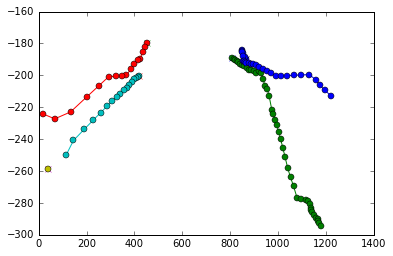

In [3]:
def displayTracks(tracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        track = np.array(tracks.items()[i][1])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o")
displayTracks(tracks, 5)

In [4]:
import pandas
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using Theano backend.


In [5]:
np.random.seed(7)

In [6]:
def buildLookbackDataset(tracks, lookback=3):
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            dataset.append(np.array(track[i-lookback:i+1]).ravel())
    return dataset
                
dataset = buildLookbackDataset(tracks) 
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [8]:
# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

(17132, 8439)


In [9]:
xtrain = np.matrix(train[:,0:6])
ytrain = np.matrix(train[:,6:])
xtest = np.matrix(test[:,0:6])
ytest = np.matrix(test[:,6:])

In [10]:
# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 3, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 3, 2))

In [11]:
xtrain[0].shape


(3, 2)

In [12]:
model = Sequential()
model.add(LSTM(32, input_shape=(3,2)))
model.add(Dense(2))
model.compile(loss='mean_squared_error', optimizer='adam')
model.load_weights('cv-mu-weights17.h5')

In [13]:
trainPredict = model.predict(xtrain)
testPredict = model.predict(xtest)
# invert predictions
#trainPredict = scaler.inverse_transform(np.concatenate((xtrain.reshape(xtrain.shape[0], xtrain.shape[2]),trainPredict), axis=1))[:,2:]
#trainY = scaler.inverse_transform([trainY])
#testPredict = scaler.inverse_transform(testPredict)
#testY = scaler.inverse_transform([testY])
# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(ytrain, trainPredict))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(ytest, testPredict))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 0.0073311 RMSE
Test Score: 0.0073196 RMSE


In [14]:
scaledPredictTrain = scaler.inverse_transform(np.concatenate((ytrain,trainPredict,ytrain,trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((ytest,testPredict,ytest,testPredict), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,0:2], scaledPredictTrain[:,2:4]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,0:2], scaledPredictTest[:,2:4]))
print('Test Score: %.7f RMSE' % (testScore))

print ytrain.shape

Train Score: 3.7592978 RMSE
Test Score: 3.3335375 RMSE
(17132, 2)


In [15]:
#print model.predict(np.array(tracks.items()[0][1][0]).reshape(1,1,2))
print tracks.items()[0][1][0]
print tracks.items()[0][1][1]

[777.654416, 165.681078]
[781.156791, 165.186175]


In [16]:
print np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
orig_scale=np.array(tracks.items()[0][1][0]+tracks.items()[0][1][1]+tracks.items()[0][1][2]\
               +tracks.items()[0][1][3]).reshape(1,-1)
l = scaler.transform(orig_scale)
print l
#x = l[0:2].reshape(1,1,2)
#y = l[2:]

[[ 777.654416   165.681078   781.156791   165.186175   784.809185
   164.670002   788.6214485  164.131158 ]]
[[ 0.62446123  0.09930999  0.62646688  0.09671893  0.63003074  0.0957425
   0.63346208  0.08985109]]


In [17]:
# Note this will predict the new point one frame ahead and build a track by 
# using measurements from the previous measurement.
# The first prediction is exactly the first measurement
# The last prediction is emitted because we know that the object is gone
# but currently the model has no method for predicting the death of an object
def rebuildTracks(tracks, model):
    predTracks = {}
    for track in tracks.items():
        predTracks[track[0]] = []
        t = predTracks[track[0]]
        for i, pos in enumerate(track[1]):
            if i < 3:
                t.append(pos)
            else:
                # scale and resize
                p1 = track[1][i-3]
                p2 = track[1][i-2]
                p3 = track[1][i-1]
                p = scaler.transform(np.array(p1+p2+p3+p3).reshape(1,-1))[0][0:6].reshape(1,3,2)
                # predict
                pred = model.predict(p).reshape(1,2).tolist()
                pred = scaler.inverse_transform(np.array(pred[0]+pred[0]+pred[0]+pred[0])\
                                                .reshape(1,-1))[0][0:2]
                t.append(pred)
    return predTracks

In [18]:
predictedTracks = rebuildTracks(tracks,model)

In [19]:
def displayPredictedTracks(tracks,predictedTracks, k):
    for i in np.random.choice(len(tracks.items()), k):
        if i / float(len(tracks.items())) < .67:
            print "Training"
        else:
            print "Testing"
        print "%d of %d"% (i, len(tracks.items()))
        key = tracks.items()[i][0]
        track = np.array(tracks.items()[i][1])
        t2 = np.array(predictedTracks[key])
        plt.plot(track[0,0], -track[0,1], marker="x")
        plt.plot(track[:,0], -track[:,1], marker="o", color='b')
        plt.plot(t2[:,0], -t2[:,1], marker="s", color='r')


Training
178 of 579


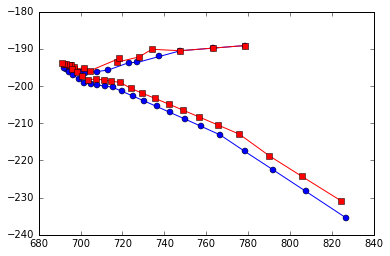

In [40]:
displayPredictedTracks(tracks,predictedTracks, 1)

In [21]:
mu_x = 28.0064938099
mu_y = 2.72131484714
def mle_var(tracks, predTracks):
    variances = {}
    x = []
    y = []
    for (key, track) in tracks.items():
        variances[key] = []
        for j, point in enumerate(track):
            x = ((point[0] - predictedTracks[key][j][0])**2)
            y = ((point[1] - predictedTracks[key][j][1])**2)
            variances[key].append((x,y))
    return variances

In [22]:
vs = mle_var(tracks, predictedTracks)

In [23]:
vs.items()[0][1][:10]


[(0.0, 0.0),
 (0.0, 0.0),
 (0.0, 0.0),
 (0.0032107292246169095, 0.6712348681099275),
 (0.68580779599035513, 1.2600218616160057),
 (0.066646532679107501, 0.85388158918321189),
 (0.069175925133314664, 0.96911214635041987),
 (0.070435062706205781, 0.98423321997403102),
 (0.071031549514651585, 0.99920627934758066),
 (0.28011419831059087, 0.41518689511761636)]

In [41]:
def buildVarDataset(tracks, predTracks, variance, lookback=3):
    dataset = []
    for key, track in tracks.items():
        for i, pos in enumerate(track):
            if i < lookback:
                continue
            gt = np.array(track[i-lookback:i]).ravel()
            pred = np.array(predTracks[key][i])
            var = np.array(variance[key][i])
            row = np.concatenate((gt, pred, var))
            dataset.append(row)
    return dataset
                
dataset = buildVarDataset(tracks, predictedTracks, vs) 
dataset = np.array(dataset)
# each row in the dataset is the x1, x2, y1, y2 
# where x1, x2 are the coordinate of previous position and y1,y2 are 
# coordinates of the next position or the location that should be predicted



In [58]:
# np.set_printoptions(suppress=True)
# plt.hist(dataset[:,8].clip(0,100))
# plt.show()
# plt.hist(dataset[:,9].clip(0,5))
# plt.show()
dataset[:,8] = dataset[:,8].clip(0,100)
dataset[:,9] = dataset[:,9].clip(0,50)

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into test and train
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

xtrain = np.matrix(train[:,0:8])
ytrain = np.matrix(train[:,8:])
xtest = np.matrix(test[:,0:8])
ytest = np.matrix(test[:,8:])

# reshape input to be [samples, time steps, features]
xtrain = np.reshape(np.array(xtrain), (xtrain.shape[0], 4, 2))
xtest = np.reshape(np.array(xtest), (xtest.shape[0], 4, 2))

xtrain[0].shape

(17132, 8439)


(4, 2)

In [60]:
import pickle
with open('varscaler-big.pickle', 'w') as handle:
    pickle.dump(scaler, handle)

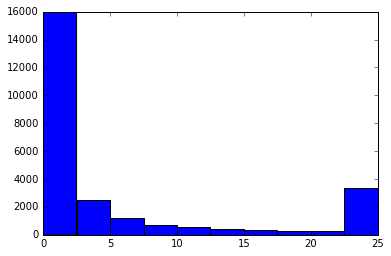

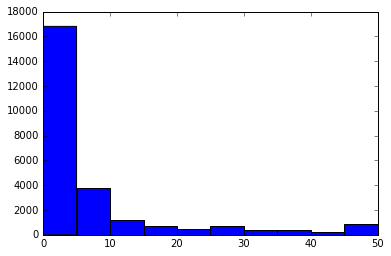

In [48]:
plt.hist(dataset[:,8].clip(0,25))
plt.show()
plt.hist(dataset[:,9].clip(0,50))
plt.show()

In [61]:
# Train LSTM based on distances
varmodel = Sequential()
varmodel.add(LSTM(32, input_shape=(4,2)))
varmodel.add(Dense(2))
adam = keras.optimizers.Adam(lr=0.01)
varmodel.compile(loss='mean_squared_error', optimizer='adam')
varmodel.load_weights('cv-cov-weights17.h5')
#varmodel.fit(xtrain, ytrain, nb_epoch=10, batch_size=1, verbose=2)

In [62]:
trainPredict = varmodel.predict(xtrain)
testPredict = varmodel.predict(xtest)

scaledYTrain = scaler.inverse_transform(np.concatenate((xtrain.reshape((xtrain.shape[0],8)),ytrain), axis=1))
scaledYTest = scaler.inverse_transform(np.concatenate((xtest.reshape((xtest.shape[0],8)),ytest), axis=1))
scaledPredictTrain = scaler.inverse_transform(np.concatenate((xtrain.reshape((xtrain.shape[0],8)),trainPredict), axis=1))
scaledPredictTest = scaler.inverse_transform(np.concatenate((xtest.reshape((xtest.shape[0],8)),testPredict), axis=1))

trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,8:], scaledYTrain[:,8:]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,8:], scaledYTest[:,8:]))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 12.0350625 RMSE
Test Score: 10.5620819 RMSE


In [63]:
trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,8:9], scaledYTrain[:,8:9]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,8:9], scaledYTest[:,8:9]))
print('Test Score: %.7f RMSE' % (testScore))
trainScore = math.sqrt(mean_squared_error(scaledPredictTrain[:,9:], scaledYTrain[:,9:]))
print('Train Score: %.7f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(scaledPredictTest[:,9:], scaledYTest[:,9:]))
print('Test Score: %.7f RMSE' % (testScore))

Train Score: 15.8114793 RMSE
Test Score: 13.7176666 RMSE
Train Score: 6.2994114 RMSE
Test Score: 5.9110721 RMSE


In [64]:
np.set_printoptions(suppress=True)
print scaledYTest[140:160,8:]
print scaledPredictTest[140:160,8:]
 

[[   1.364423      8.74759421]
 [   1.21694362    2.50805669]
 [   1.54283267    6.25819144]
 [   1.8454276     7.28919039]
 [   0.45943719    5.13973381]
 [   1.13951413    7.04294211]
 [   1.64165592    7.68735586]
 [   0.00037584   50.        ]
 [   0.23308839   24.27647108]
 [   0.02172877   15.032684  ]
 [   2.09992126   27.57175882]
 [   2.53249721   22.26363919]
 [  18.48686198   50.        ]
 [  47.99929356   50.        ]
 [ 100.           18.75836022]
 [  43.99598364   37.27157625]
 [ 100.           43.520428  ]
 [  14.41643328   47.36757467]
 [  20.5018467    50.        ]
 [  13.30384314   10.168659  ]]
[[  0.76729515   8.10243413]
 [  0.6281943    8.87538493]
 [  0.73548415   8.66248906]
 [  1.50325158   8.9857541 ]
 [  1.90626838   9.42569375]
 [  2.1944926    9.49809402]
 [  2.84963109   9.83953774]
 [  3.49904158  10.28626859]
 [  6.67393514  16.75448865]
 [ 13.01469512  24.63521957]
 [ 18.80172647  30.66572845]
 [ 28.03609377  36.39882505]
 [ 35.82101172  30.56291938]
 [

In [33]:
#varmodel.save_weights('variance_32h_weights.h5')

In [68]:
print np.argmin(scaledPredictTest[:,8])
print np.min(scaledPredictTest[:,8])

43
-9.47068026282


In [69]:
np.set_printoptions(suppress=True)
print dataset[trainPredict.shape[0]+43,:]
print testPredict[43]

[ 0.23777909  0.31898035  0.2578816   0.33509974  0.27719069  0.35221502
  0.29035154  0.37177506  0.00304634  0.04779353]
[-0.0947068   0.10324816]


In [36]:
varmodel.predict(dataset[777,:8].reshape(1,4,2))

array([[ 0.20565914,  0.08959736]])